<a href="https://colab.research.google.com/github/mitrasubham/OpenCVLLM/blob/main/Table_detection_and_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab.patches import cv2_imshow

In [3]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 21.9 MB/s eta 0:00:00


In [4]:
import easyocr
reader = easyocr.Reader(['th','en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [5]:
!apt install libtesseract-dev tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,560 kB of archives.
After this operation, 31.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.3 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:5 http://arc

In [6]:
!pip install pytesseract > /dev/null

In [7]:
import pandas as pd
import cv2
import numpy as np
import pytesseract

In [14]:
def table_detection(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, img_bin) = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bin = cv2.bitwise_not(img_bin)

    kernel_length_v = (np.array(img_gray).shape[1])//120
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length_v))
    im_temp1 = cv2.erode(img_bin, vertical_kernel, iterations=3)
    vertical_lines_img = cv2.dilate(im_temp1, vertical_kernel, iterations=3)

    kernel_length_h = (np.array(img_gray).shape[1])//40
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length_h, 1))
    im_temp2 = cv2.erode(img_bin, horizontal_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(im_temp2, horizontal_kernel, iterations=3)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    table_segment = cv2.addWeighted(vertical_lines_img, 0.5, horizontal_lines_img, 0.5, 0.0)
    table_segment = cv2.erode(cv2.bitwise_not(table_segment), kernel, iterations=2)
    thresh, table_segment = cv2.threshold(table_segment, 0, 255, cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(table_segment, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    count = 0

    full_list=[]
    row=[]
    data=[]
    first_iter=0
    firsty=-1
    table_data=[]
    ctr=0
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)

        if  h > 9 and h<100:
            if first_iter==0:
              first_iter=1
              firsty=y
            if firsty!=y:
              row.reverse()
              full_list.append(row)
              row=[]
              data=[]
            #print(x,y,w,h)
            cropped = img[y:y + h, x:x + w]
            cv2_imshow(cropped)
            bounds = reader.readtext(cropped)
            text = pytesseract.image_to_string(cropped,config='--psm 6')
            ctr=ctr+1
            print("line ",ctr, text,"\n")
            #print(text)
            #print(bounds)


            try:
              data.append(bounds[0][1])
              data.append(w)
              row.append(data)
              data=[]
            except:
              data.append("--")
              data.append(w)
              row.append(data)
              data=[]
            firsty=y
        cv2.rectangle(img,(x, y),(x + w, y + h),(0, 255, 0), 2)
        #cv2_imshow(img)
    full_list.reverse()
    #text = pytesseract.image_to_string(img,config='--psm 7')
    #print(full_list)

    new_data=[]
    new_row=[]
    for i in full_list:
      for j in i:
        new_row.append(j[0])
      new_data.append(new_row)
      new_row=[]
    #print(new_data)

    # Convert list of lists into a DataFrame
    df = pd.DataFrame(new_data)
    df = df.map(lambda x: '' if pd.isna(x) else x)
    from tabulate import tabulate
    #table = tabulate(df, headers='firstrow', tablefmt='grid')
    table = tabulate(df, tablefmt='grid')

    # Print DataFrame
    #print(table)



In [35]:
def table_detection(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #(thresh, img_bin) = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #img_bin = cv2.bitwise_not(img_bin)
    #bw = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)
    #print("img_bin")
    #cv2_imshow(img_bin)
    bw = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)
    print("img_gray")
    #cv2_imshow(bw)
    img_bin=bw

    #bw = cv2.adaptiveThreshold(~img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)
    #print("~img_gray")
    #cv2_imshow(bw)
    # Create horizontal and vertical masks
    #horizontal = bw.copy()

    kernel_length_v = (np.array(img_bin).shape[1])//120
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length_v))
    im_temp1 = cv2.erode(img_bin, vertical_kernel, iterations=3)
    vertical_lines_img = cv2.dilate(im_temp1, vertical_kernel, iterations=3)

    kernel_length_h = (np.array(img_bin).shape[1])//40
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length_h, 1))
    im_temp2 = cv2.erode(img_bin, horizontal_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(im_temp2, horizontal_kernel, iterations=3)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    table_segment = cv2.addWeighted(vertical_lines_img, 0.5, horizontal_lines_img, 0.5, 0.0)
    table_segment = cv2.erode(cv2.bitwise_not(table_segment), kernel, iterations=2)
    thresh, table_segment = cv2.threshold(table_segment, 0, 255, cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(table_segment, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    count = 0

    full_list=[]
    row=[]
    data=[]
    first_iter=0
    firsty=-1
    table_data=[]
    ctr=0
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)

        if  h > 9 and h<100:
            if first_iter==0:
              first_iter=1
              firsty=y
            if firsty!=y:
              row.reverse()
              full_list.append(row)
              row=[]
              data=[]
            #print(x,y,w,h)
            cropped = img[y:y + h, x:x + w]
            cv2_imshow(cropped)
            bounds = reader.readtext(cropped)
            text = pytesseract.image_to_string(cropped,config='--psm 6')
            ctr=ctr+1
            print("line ",ctr, text,"\n")
            #print(text)
            #print(bounds)


            try:
              data.append(bounds[0][1])
              data.append(w)
              row.append(data)
              data=[]
            except:
              data.append("--")
              data.append(w)
              row.append(data)
              data=[]
            firsty=y
        cv2.rectangle(img,(x, y),(x + w, y + h),(0, 255, 0), 2)
        #cv2_imshow(img)
    full_list.reverse()
    #text = pytesseract.image_to_string(img,config='--psm 7')
    #print(full_list)

    new_data=[]
    new_row=[]
    for i in full_list:
      for j in i:
        new_row.append(j[0])
      new_data.append(new_row)
      new_row=[]
    #print(new_data)

    # Convert list of lists into a DataFrame
    df = pd.DataFrame(new_data)
    df = df.map(lambda x: '' if pd.isna(x) else x)
    from tabulate import tabulate
    #table = tabulate(df, headers='firstrow', tablefmt='grid')
    table = tabulate(df, tablefmt='grid')

    # Print DataFrame
    #print(table)



img_gray


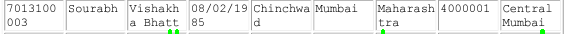

line  1 (7013100 Sourabh (Vishakh 08/02/19|Chinchwa Mumbai Maharash|4000001 Central
lo03 la Bhatt 85 a tra ‘Mumbai
 



line  2  



line  3 eT
 



line  4  



line  5  



line  6  



line  7 |
 



line  8  



line  9  



line  10  



line  11  



line  12 , |
 



line  13 OY
 



line  14 |
 



line  15 sed
 



line  16  



line  17  



line  18  



line  19 ||
 



line  20  



line  21  



line  22 |
 



line  23  



line  24  



line  25  



line  26  



line  27 “|
 



line  28 nh
 



line  29  



line  30 2
 



line  31 a
 



line  32  



In [36]:
table_detection("singleline.png")